# XSeg Face Segmentation

This notebook demonstrates face segmentation using the **XSeg** model from DeepFaceLab.

XSeg outputs a mask for face regions. Unlike BiSeNet which works on bbox crops, XSeg requires 5-point landmarks for face alignment.

## 1. Install UniFace

In [1]:
%pip install -q uniface

# Clone repo for assets (Colab only)
import os
if 'COLAB_GPU' in os.environ or 'COLAB_RELEASE_TAG' in os.environ:
    if not os.path.exists('uniface'):
        !git clone --depth 1 https://github.com/yakhyo/uniface.git
    os.chdir('uniface/examples')

Note: you may need to restart the kernel to use updated packages.


## 2. Import Libraries

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import uniface
from uniface.detection import RetinaFace
from uniface.parsing import XSeg

print(f"UniFace version: {uniface.__version__}")

UniFace version: 2.2.1


## 3. Initialize Models

XSeg requires face detection with landmarks. We use RetinaFace for detection and XSeg for segmentation.

In [3]:
# Initialize detector and parser
detector = RetinaFace()
parser = XSeg()

print(f"XSeg input size: {parser.input_size}")
print(f"Align size: {parser.align_size}")
print(f"Blur sigma: {parser.blur_sigma}")

XSeg input size: (256, 256)
Align size: 256
Blur sigma: 0


## 4. Helper Functions

In [4]:
def apply_mask_overlay(image, mask, color=(0, 255, 0), alpha=0.5):
    """Apply colored mask overlay on image."""
    overlay = image.copy().astype(np.float32)

    # Create colored overlay where mask is positive
    color_overlay = np.zeros_like(image, dtype=np.float32)
    color_overlay[:] = color

    mask_3ch = mask[..., np.newaxis]
    overlay = overlay * (1 - mask_3ch * alpha) + color_overlay * mask_3ch * alpha

    return overlay.clip(0, 255).astype(np.uint8)


def show_results(original, mask, result, title="XSeg Result"):
    """Display original, mask, and result side by side."""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Original")
    axes[0].axis("off")

    axes[1].imshow(mask, cmap="gray")
    axes[1].set_title("Mask")
    axes[1].axis("off")

    axes[2].imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    axes[2].set_title("Overlay")
    axes[2].axis("off")

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

## 5. Process Single Image

Image shape: (1200, 1200, 3)
Detected 1 face(s)
Mask shape: (1200, 1200)
Mask range: [0.000, 1.000]


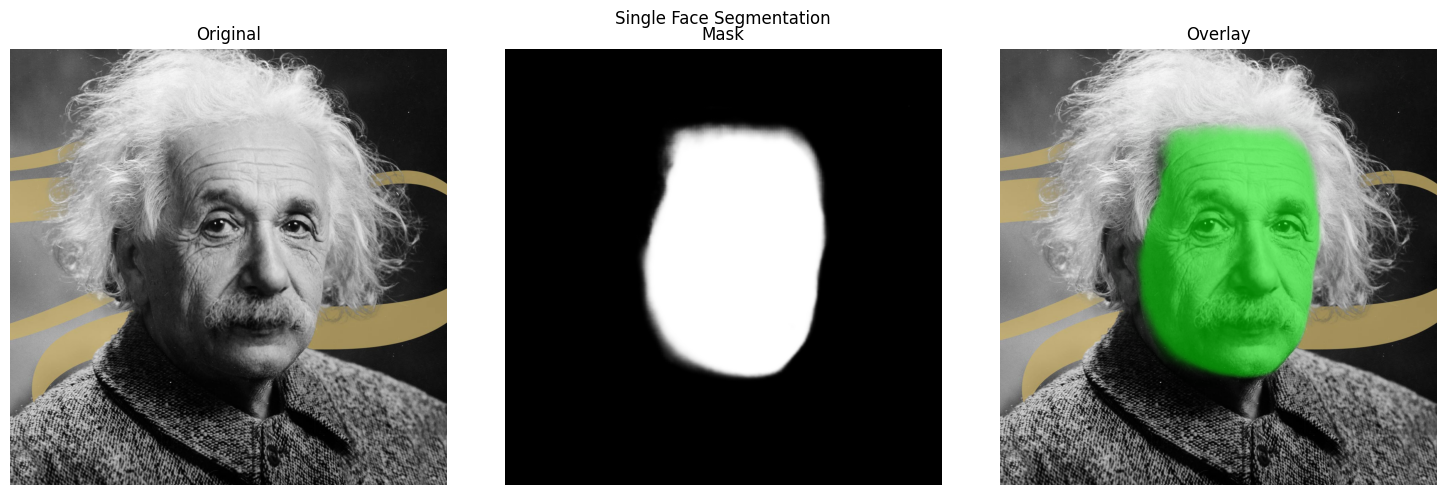

In [5]:
# Load image
image_path = "../assets/einstien.png"
image = cv2.imread(image_path)
print(f"Image shape: {image.shape}")

# Detect faces
faces = detector.detect(image)
print(f"Detected {len(faces)} face(s)")

# Parse first face
if len(faces) > 0 and faces[0].landmarks is not None:
    face = faces[0]
    mask = parser.parse(image, face.landmarks)

    print(f"Mask shape: {mask.shape}")
    print(f"Mask range: [{mask.min():.3f}, {mask.max():.3f}]")

    # Visualize
    result = apply_mask_overlay(image, mask)
    show_results(image, mask, result, "Single Face Segmentation")

## 6. Configurable Parameters

XSeg has two main parameters:
- `align_size`: Face alignment output size (default: 256)
- `blur_sigma`: Gaussian blur for mask smoothing (default: 0 = raw output)

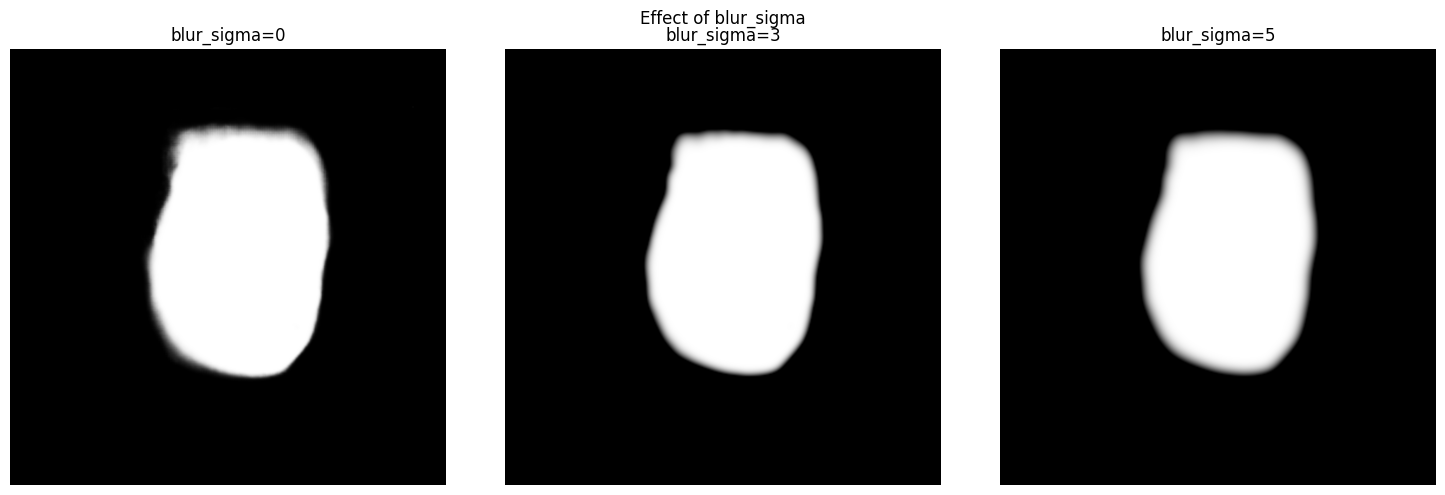

In [6]:
# Load image
image_path = "../assets/einstien.png"
image = cv2.imread(image_path)

# Detect face
faces = detector.detect(image)
landmarks = faces[0].landmarks

# Compare different blur settings
blur_values = [0, 3, 5]

fig, axes = plt.subplots(1, len(blur_values), figsize=(15, 5))

for i, blur in enumerate(blur_values):
    parser_test = XSeg(blur_sigma=blur)
    mask = parser_test.parse(image, landmarks)

    axes[i].imshow(mask, cmap="gray")
    axes[i].set_title(f"blur_sigma={blur}")
    axes[i].axis("off")

plt.suptitle("Effect of blur_sigma")
plt.tight_layout()
plt.show()

## 7. Using parse_aligned

If you already have aligned face crops, use `parse_aligned()` directly.

Aligned face shape: (256, 256, 3)
Mask shape: (256, 256)


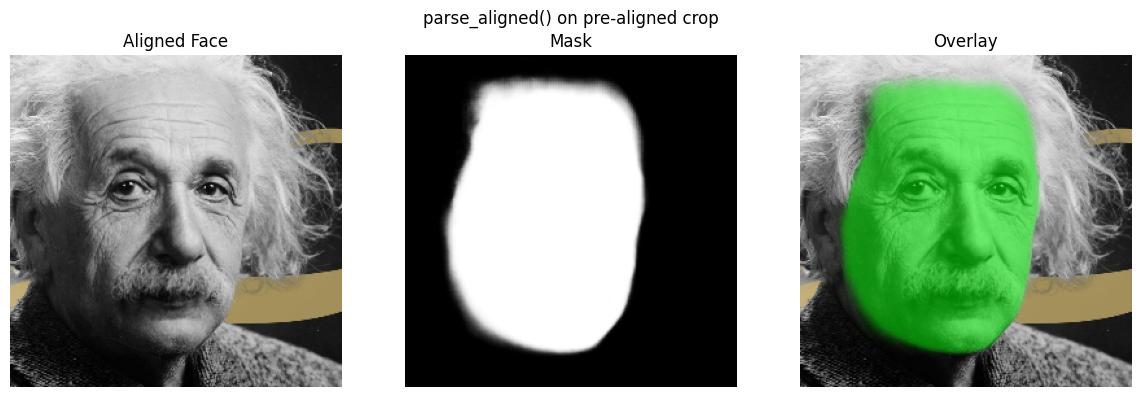

In [7]:
from uniface.face_utils import face_alignment

# Load and detect
image = cv2.imread("../assets/einstien.png")
faces = detector.detect(image)
landmarks = faces[0].landmarks

# Align face manually
aligned_face, inverse_matrix = face_alignment(image, landmarks, image_size=256)
print(f"Aligned face shape: {aligned_face.shape}")

# Parse aligned crop directly
mask = parser.parse_aligned(aligned_face)
print(f"Mask shape: {mask.shape}")

# Visualize
result = apply_mask_overlay(aligned_face, mask)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(cv2.cvtColor(aligned_face, cv2.COLOR_BGR2RGB))
axes[0].set_title("Aligned Face")
axes[0].axis("off")

axes[1].imshow(mask, cmap="gray")
axes[1].set_title("Mask")
axes[1].axis("off")

axes[2].imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
axes[2].set_title("Overlay")
axes[2].axis("off")

plt.suptitle("parse_aligned() on pre-aligned crop")
plt.tight_layout()
plt.show()

## 8. XSeg vs BiSeNet

| Feature | XSeg | BiSeNet |
|---------|------|--------|
| Output | Mask [0, 1] | 19 class labels |
| Input | Requires landmarks | Works on bbox crops |
| Use case | Face region extraction | Facial component parsing |
| Origin | DeepFaceLab | CelebAMask-HQ |

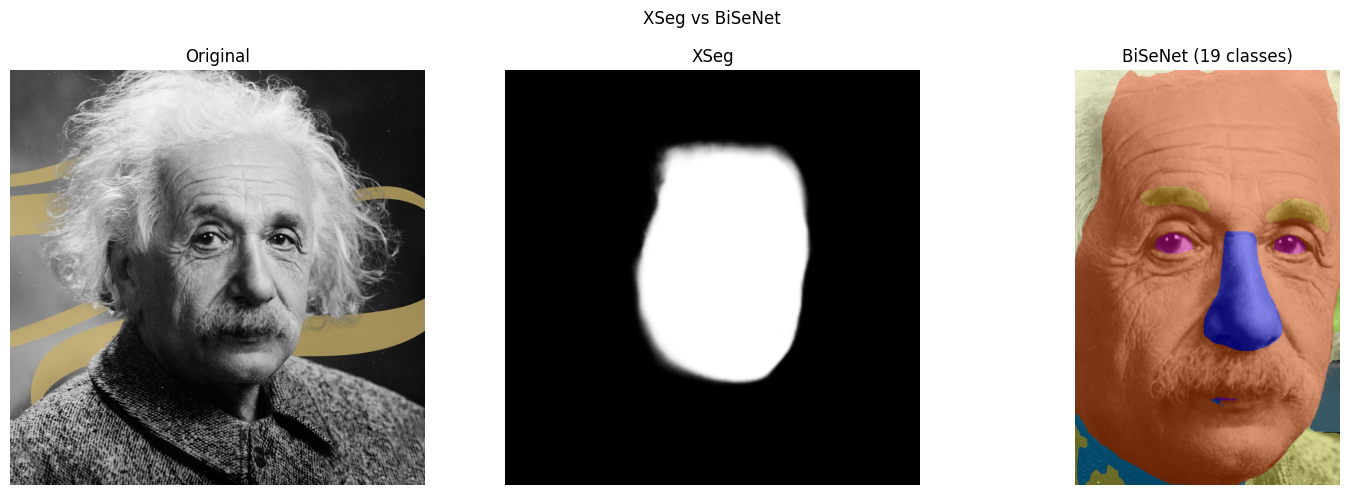

In [8]:
from uniface.parsing import BiSeNet
from uniface.visualization import vis_parsing_maps

# Load image and detect
image = cv2.imread("../assets/einstien.png")
faces = detector.detect(image)
face = faces[0]

# XSeg: requires landmarks
xseg_mask = parser.parse(image, face.landmarks)

# BiSeNet: works on bbox crop
bisenet = BiSeNet()
x1, y1, x2, y2 = map(int, face.bbox[:4])
face_crop = image[y1:y2, x1:x2]
bisenet_mask = bisenet.parse(face_crop)

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axes[0].set_title("Original")
axes[0].axis("off")

axes[1].imshow(xseg_mask, cmap="gray")
axes[1].set_title("XSeg")
axes[1].axis("off")

face_rgb = cv2.cvtColor(face_crop, cv2.COLOR_BGR2RGB)
bisenet_vis = vis_parsing_maps(face_rgb, bisenet_mask, save_image=False)
axes[2].imshow(bisenet_vis)
axes[2].set_title("BiSeNet (19 classes)")
axes[2].axis("off")

plt.suptitle("XSeg vs BiSeNet")
plt.tight_layout()
plt.show()

## 9. Application: Face Masking

Use XSeg mask to extract or replace face regions.

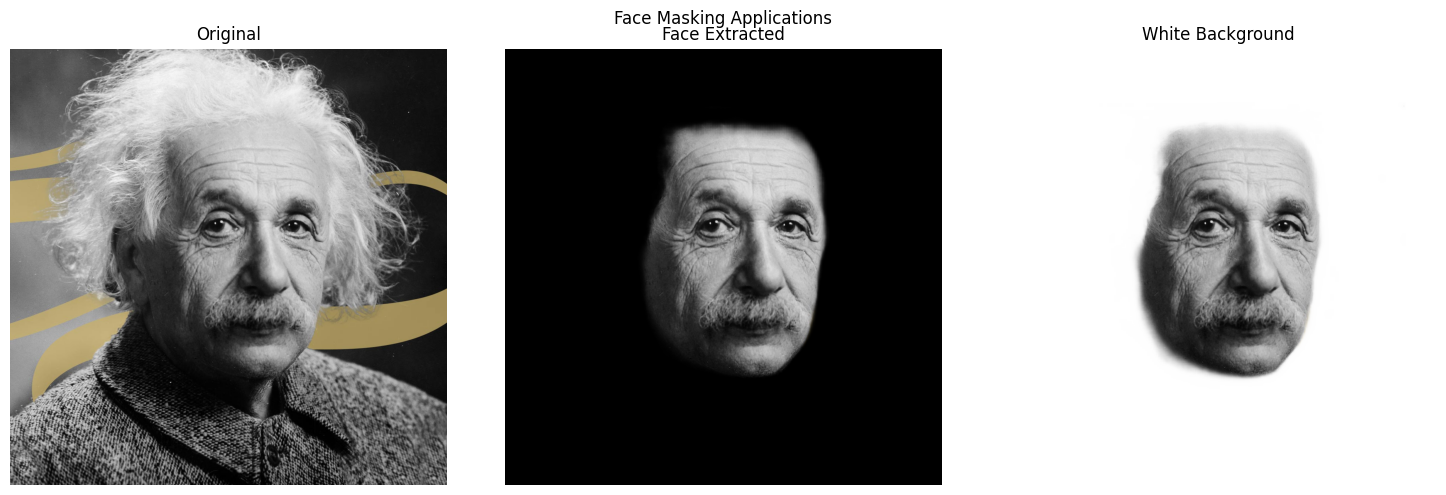

In [9]:
# Load image
image = cv2.imread("../assets/einstien.png")
faces = detector.detect(image)
mask = parser.parse(image, faces[0].landmarks)

# Extract face only
mask_3ch = np.stack([mask] * 3, axis=-1)
face_only = (image * mask_3ch).astype(np.uint8)

# Replace background with white
white_bg = np.ones_like(image) * 255
face_on_white = (image * mask_3ch + white_bg * (1 - mask_3ch)).astype(np.uint8)

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axes[0].set_title("Original")
axes[0].axis("off")

axes[1].imshow(cv2.cvtColor(face_only, cv2.COLOR_BGR2RGB))
axes[1].set_title("Face Extracted")
axes[1].axis("off")

axes[2].imshow(cv2.cvtColor(face_on_white, cv2.COLOR_BGR2RGB))
axes[2].set_title("White Background")
axes[2].axis("off")

plt.suptitle("Face Masking Applications")
plt.tight_layout()
plt.show()

## Summary

XSeg provides face segmentation using landmark-based alignment:

- **`parse(image, landmarks)`** - Full pipeline: align, segment, warp back
- **`parse_aligned(face_crop)`** - For pre-aligned crops
- **`parse_with_inverse(image, landmarks)`** - Returns mask + crop + inverse matrix

Parameters:
- `align_size` - Face alignment size (default: 256)
- `blur_sigma` - Mask smoothing (default: 0 = raw)